### Exploring Chemical and Biological Data With BidingDB and the RDKit
In this notebook we will use the [BindingDB](https://bindingdb.org/rwd/bind/index.jsp), database of chemical structures and biological activity values extracted from the chemical literature, to search for compounds that bind to the [SARS-CoV-2 main  protease](https://pubmed.ncbi.nlm.nih.gov/35845352/).  In addition to hosting data from the scientifiic literature, BindingDB also has data extracted from chemical patents.  We will extract the data from a SARS-CoV-2 inhibitor patent, explore this data, and save a representative subset for a subsequent docking analysis. 

### 1. Searching BindingDB and Downloading Chemical Structures and Data
We begin by accessing the BindingDB website at [https://bindingdb.org](https://bindingdb.org). Click on the **Publications** link on the left, then click on the **US Patent** link. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_01.png"/>     
   
This will bring up a results page like the one below.  This page shows recently curated patents and allows us to search by patent number.  Enter this text into the box, [US20240293380](https://patents.google.com/patent/US20240293380A1/fr).  Once you click on the **Search** button, BindingDB will find compounds that were curated from this patent by scientists as the Cleveland Clinic, describing a set of protease inhibitors. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_02.png"/>  
   
This will take you to a page with details the 75 compounds extracted from US20240293380.  The page shows chemical structures as well as links to other databases. To download the information about all structures from this patent, first click on the **Add all pages** link, followed by the **Make dataset** button indicated by the arrows in figure below. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_03.png"/>   
   
By selecting the **Tab Delimited (TSV)** radio button and pressing the **Go** button, we can download the data.  This download requires registration with BindingDB.  To streamline this tutorial, we will load the file directly from GitHub instead. 
   
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/binding_db_04.png"/>    

### 2. Install and Import the necessary Python libraries
The next cell will install the Python libraries necessary for this notebook.  Note that the libraries are only installed if the notebook is running in Google Colab.  The installation process generates a lot of output, which we suppress with the **%%caputure%%** magic command.  If you run into problems, remove **%%capture%%** to see the cell output. 

In [1]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install pandas mols2grid seaborn rdkit matplotlib useful_rdkit_utils scikit-learn ipywidgets

We are the capabilities provided by these libraries. 

- [pandas](https://pandas.pydata.org/) - data analysis and manipulation
- [mols2grid](https://github.com/cbouy/mols2grid) - display interactive grids of chemical structures and data
- [seaborn](https://seaborn.pydata.org/) - plotting and data visualization
- [rdkit](https://www.rdkit.org/) - Open source cheminformatics
- [matplotlib](https://matplotlib.org/) - data visualization
- [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/) - Cheminformatics utilities
- [scikit-learn](https://scikit-learn.org/stable/) - Machine learning
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Interactive tools in Jupyter notebooks

In the cell below, we load the python libraries

In [2]:
import pandas as pd
import mols2grid
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
import useful_rdkit_utils as uru
from IPython.core.display import HTML

### 3. Read the file we downloaded from PDBBind into a Pandas dataframe. 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/pdb/monomers_12285.tsv",sep="\t")

As we can see, the data we extracted from BindingDB has many fields. 

In [4]:
df.columns

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Target in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID of Ligand',
       'PubChem SID of Ligand', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand',
       'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand',
       'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (>1 implies a multichain complex)',
       'BindingDB Target Chain Sequ

To make things simpler, we'll rename a couple of columns.

In [5]:
df.rename(columns={'Ligand SMILES':'SMILES'},inplace=True)
df.rename(columns={'BindingDB Ligand Name':'Name'},inplace=True)

We can aslo see that the data has 75 rows, with each compound corresponding to a row.  For our purposes, we'll focus on a few fields. 
- SMILES - the chemical structure of the compound
- Name - the internal identifier Binding DB provides for each compund
- IC50 (nM) - the IC50 in nM.

The IC50, or half maximal inhibitory concentration, is a measure of a substance's potency in inhibiting a specific biological or biochemical function. It represents the concentration of an inhibitor needed to reduce a particular biological process or component by 50% in vitro, and is commonly used to assess the effectiveness of drugs in pharmacological research. IC50 values are typically expressed as nM concentrations and provide a quantitative indication of how much of an inhibitory substance is required to achieve half-maximal inhibition of a given target or process

In [6]:
len(df)

75

We can use [mols2grid](https://github.com/cbouy/mols2grid) to browse the chemcial structures of the 75 compounds. 

In [7]:
mols2grid.display(df,smiles_col="SMILES",subset=["img","IC50 (nM)"])

### 3. Visualizing the Activity Distribution
First, let's set some reasonable defaults for plots. 

In [8]:
sns.set(rc={'figure.figsize': (5,5 )})
sns.set_style('whitegrid')
sns.set_context('notebook')

Let's look at the the IC50 distribution for the 75 compounds.  As we can see below, the default view isn't very helpful. 

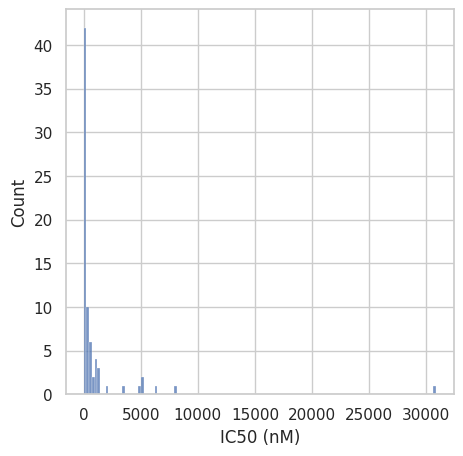

In [9]:
ax = sns.histplot(df["IC50 (nM)"])

It's oftent easier to look at the distribution of **pIC50** values, where pIC50 is the negative log of the IC50. 

In [10]:
df["pIC50"] = -np.log10(df["IC50 (nM)"] * 1e-9)

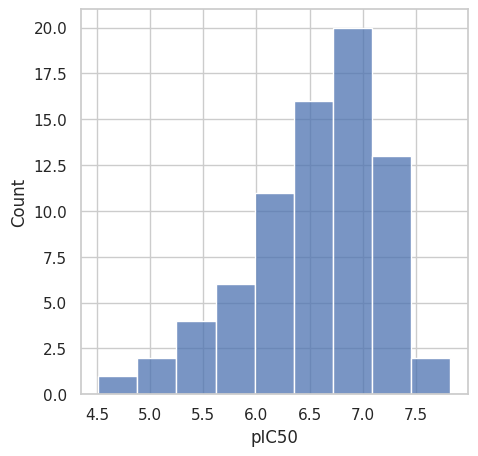

In [11]:
ax = sns.histplot(df.pIC50)

For visualization it's often helpful to bin the activity into high, medium, and low bins.  Here well put compounds with 6 < pIC50 < 7 (0.1-1$\micro$M) into the "medium" bin, and compounds with pIC50 > 7 into the "high" bin. 

In [12]:
df["activity"] = pd.cut(df.pIC50,bins=[0,6,7,100],labels=["low","med","high"],right=False)

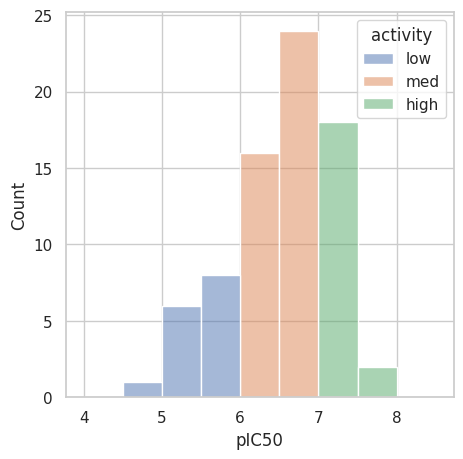

In [13]:
ax = sns.histplot(x="pIC50",hue="activity",data=df,bins=np.arange(4,9,0.5))

Now that we have the IC50 data binned into high, med, low, we can use these categories to make plots showing mulitple parameters.  In the cells below we'll make a scatterplot of molecular weight (MW) vs LogP, a measure of lipophilicity. We can then color the plot by activty and see whether acitivity is driven by MW or LogP. 

To calculate MW and LogP we need to add an RDKit molecule column to the dataframe.  As we will see in next couple of cells, the Pandas [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method provides a handy way of performing operations on an entire dataframe column. 

In [14]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Now that the dataframe has a **mol** column with the RDKit molecules, we can use **apply** to calculate MW and LogP. 

In [15]:
df['MW'] = df.mol.apply(uru.MolWt)
df['LogP'] = df.mol.apply(uru.MolLogP)

Use [seaborn](https://seaborn.pydata.org/) to make the scatterplot of MW vs LogP, colored by **activity**. Note that while we don't have a clear relationship between either MW or LogP and activity, the smallest molecules tend to have low to medium activity. 

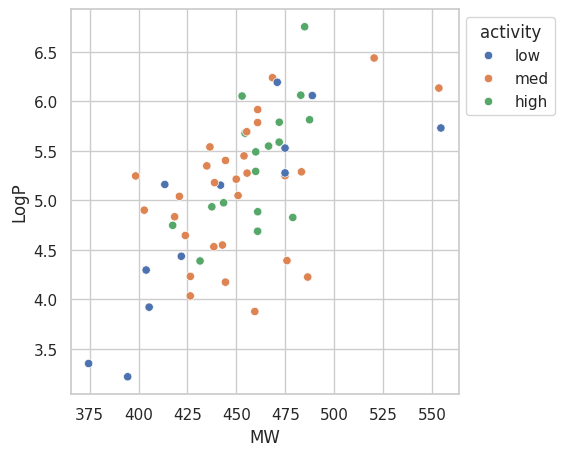

In [16]:
ax = sns.scatterplot(x="MW",y="LogP",hue="activity",data=df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### 4. Understanding the Chemistry in the Downloaded Molecules 
We downloaded 75 molecules from BindingDB.  It can often be challenging to understand the trends in sets of molecules. In the next section, we'll look at how Cheminformatics tools can aid or exploratory data analysis. As a first step in this analysis, we will see which parts are common to all 75 of the molecules.  To do this, we can use the Maxiumum Common Substructure (MCS) capability in the RDKit.  To use this capability, we must first convert the SMILES in our dataframe to RDKit molecule objects.  As above, we can use the Pandas apply method to do this. 

In [17]:
df['mol'] = df["SMILES"].apply(Chem.MolFromSmiles)

Next we can calculate the MCS. 

In [18]:
mcs = rdFMCS.FindMCS(df.mol)

To visualize the MCS, we have to convert it to an RDKit molecule object. 

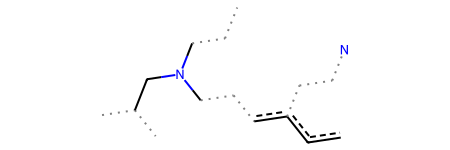

In [19]:
pat = Chem.MolFromSmarts(mcs.smartsString)
pat

The visualization above can be difficult to interpret.  The MCS tends to make more sense when we map it onto the molecules. Here we can map the MCS on to the first molecule in the dataframe and display it as a red highlight. Note how we use the utilitiy function [rd_set_image_size](https://useful-rdkit-utils.readthedocs.io/en/latest/jupyter.html#useful_rdkit_utils.jupyter_utils.rd_set_image_size) from [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/index.html) to set the image size. 

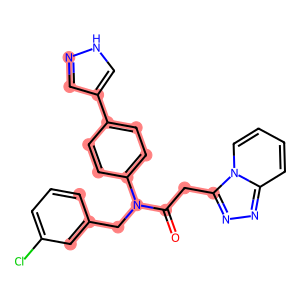

In [20]:
uru.rd_set_image_size(300,300)
df.mol.values[0].GetSubstructMatch(pat)
df.mol.values[0]

Another tool for exploring chemical datasets is the Bemis-Murcko scaffold. In this technique a molecule is reduced to a set of connected rings and linkers.  We can use the **GetScaffoldForMol**  method from the RDKit to generate Bemis-Murcko scaffolds.  

In [21]:
df['Scaffold'] = df.mol.apply(GetScaffoldForMol)

The generated scaffolds are RDKit molecule objects.  We would like to find the most frequently occuring scaffolds.  To do this, we need to convert the scaffolds to SMILES.  

In [22]:
df['Scaffold_SMILES'] = df.Scaffold.apply(Chem.MolToSmiles)

Now we can use the [value_counts_df](https://useful-rdkit-utils.readthedocs.io/en/latest/pandas.html#useful_rdkit_utils.pandas_utils.value_counts_df) method in [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/index.html) count how many times each scaffold is used.  

In [23]:
scaffold_counts_df = uru.value_counts_df(df,"Scaffold_SMILES")
scaffold_counts_df.head()

,Scaffold_SMILES,count
0,O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(-c2c[nH]...,16
1,O=C(Cc1cccnc1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1,10
2,O=C(Cc1nnc2ccccn12)N(Cc1ccccc1)c1ccc(-c2c[nH]c...,7
3,O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(C2=CCNC2...,3
4,O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccccc1,3


Use the **scaffold_counts_df** we created above to view the scaffolds and their frequencies. 

In [24]:
mols2grid.display(scaffold_counts_df,smiles_col="Scaffold_SMILES",subset=["img","count"],size=(250,250),
                  n_items_per_page=6)

Let's take a closer look at the most frequent scaffolds.  We can use the Pandas **query** method to find scaffolds that occur in at least 5 molecules.  

In [25]:
uru.value_counts_df(df,"Scaffold_SMILES").query("count > 5")

,Scaffold_SMILES,count
0,O=C(Cc1cncc2ccccc12)N(Cc1ccccc1)c1ccc(-c2c[nH]...,16
1,O=C(Cc1cccnc1)N(Cc1ccccc1)c1ccc(-c2c[nH]cn2)cc1,10
2,O=C(Cc1nnc2ccccn12)N(Cc1ccccc1)c1ccc(-c2c[nH]c...,7


In the next section, we'll look at how we can plot the activity distribution associated with each of the scaffolds specified above.  We will use the Pandas groupby function to select compounds with the same scaffold.  Once we've grouped by scaffold,  we can compare the corresponding IC50 distributions. 

In [26]:
output_list = []
for k,v in df.groupby('Scaffold_SMILES'):
    if len(v) > 5:
        mol = Chem.MolFromSmiles(k)
        mol_image = uru.mol_to_base64_image(mol)
        boxplot_image = uru.boxplot_base64_image(v.pIC50.values)
        output_list.append([mol_image, len(v),boxplot_image])
output_df = pd.DataFrame(output_list,columns=["Scaffold","Num Examples","pIC50 Distribution"])        

With the dataframe generated above, we can now visualize the activity distributions associated with the three most common scaffolds. 


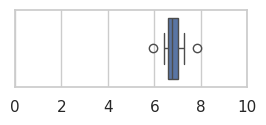
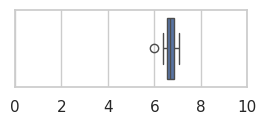
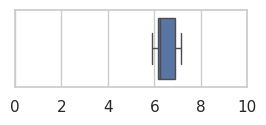

In [27]:
HTML(output_df.sort_values("Num Examples",ascending=False).to_html(escape=False))

### 5. Select and Export a Subset of the 75 Compounds for Docking
As the next part of this tutorial, we'll dock a few of the 75 molecules we extracted into a protein crystal structure of p38 kinase. Since we have limited commputational resources available, we will use clustering to select a subset of the compounds.   Clustering uses chemical fingerprits to group similar chemical structures.  In this case, we will use the Butina clustering algorithm as implemented in the RDKit.  To perform the clustering, we need to generate a different chemical fingerprint format than the one we generated above when we were performing dimensionality reduction. In this case, we will use the **get_fp** method of the useful_rdkit_utils Smi2Fp class.  

In [28]:
smi2fp = uru.Smi2Fp()
df['morgan_fp'] = df.SMILES.apply(smi2fp.get_fp)

With the fingerprint generated, we can cluster using the **taylor_butina_clustering** convenience function in useful_rdkit_utils. This adds a new field, "cluster" to the dataframe. 

In [29]:
df['cluster'] = uru.taylor_butina_clustering(df.morgan_fp)

As we did above, we can use the Pandas **value_counts** method to see how many compounds are in each cluster. The vast majority of compounds are in cluster 0. 

In [30]:
df.cluster.value_counts()

cluster
0    65
1     4
4     4
2     1
3     1
Name: count, dtype: int64

Let's select the most active compound from each cluster.  To do this we first sort the dataframe by "IC50 (nM)".  Once the dataframe is sorted, we can use the Pandas **drop_duplicates** methood to delete all but the first compound from each cluster. 

In [31]:
unique_cluster_df = df.sort_values("IC50 (nM)").drop_duplicates("cluster").copy()

Now we'd like to exort these 5 compounds as a csv file.  The dataframe contains a lot of columns, most of which we don't need.  Let's creat a list of the columns we'd like to export. 

In [32]:
columns_to_keep = ["SMILES","Name","IC50 (nM)","cluster"]

View these columns to ensure this is what we want. 

In [33]:
unique_cluster_df[columns_to_keep].sort_values("cluster")

,SMILES,Name,IC50 (nM),cluster
9,Fc1cc(Cl)cc(CN(C(=O)Cc2cncc3ccccc23)c2ccc(cc2)...,"US20240293380, Compound 12",15.0,0
0,Clc1cccc(CN(C(=O)Cc2nnc3ccccn23)c2ccc(cc2)-c2c...,"US20240293380, Compound 1",365.0,1
54,CC(C)(C)NC(=O)C(N(C(=O)Cc1cncc2ccccc12)c1ccc(c...,"US20240293380, Compound 63",1027.0,2
74,Fc1cncc(CN(C(=O)Cc2cncc(F)c2)c2ccc(cc2)C2CNC2)c1,"US20240293380, Compound 83",5225.0,3
3,Clc1cccc(CN(C(=O)Cc2cnc3ccccn23)c2ccc(cc2)-c2c...,"US20240293380, Compound 4",1146.0,4


Finally, export the five molecules as a csv file. 

In [34]:
unique_cluster_df[columns_to_keep].sort_values("cluster").to_csv("US20240293380_examples.csv",index=False)

These structures can be docked into the PDB structure [7LME](https://www.rcsb.org/structure/7lme) of the SARS-CoV-2 3CLPro. For more information on compounds similar to those in US20240293380, please see ["Structure-Based Optimization of ML300-Derived, Noncovalent Inhibitors Targeting the Severe Acute Respiratory Syndrome Coronavirus 3CL Protease (SARS-CoV-2 3CLpro)"](https://pubs.acs.org/doi/10.1021/acs.jmedchem.1c00598)